In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
relax = pd.read_csv("relax.csv", dtype={"time": np.float64})
mpi = pd.read_csv("mpi.csv", dtype={"time": np.float64})

In [44]:
relax_avg = relax.groupby("n").mean()
mpi_avg = mpi.groupby("n").mean()
re

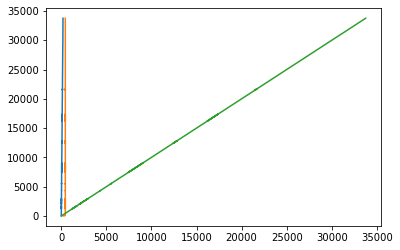

In [45]:
plt.plot(relax_avg, relax_avg["time"])